In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

In [2]:
names = ['age','workclass','fnlwgt','education','education-num',
        'marital-status','occupation','relationship','race','sex',
        'capital-gain','capital-loss','hours-per-week','native-country',
        'y']

#Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv',names=names,na_values='?')
df = df.dropna()

Text(0.5, 1.0, 'Race')

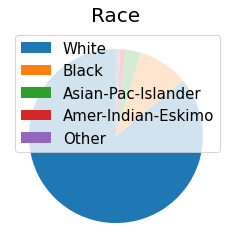

In [3]:
#Get population count by race
counts = df['race'].value_counts()
labels = counts.index

#Plot pie chart
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=15)
plt.title("Race",size=20)

In [4]:
df_fair = df[['race','sex']]

In [5]:
#Define protected features 
df_fair['priv_race'] = [1 if r=='White' else 0 for r in df_fair['race']]
df_fair['priv_sex'] = [1 if s=='Male' else 0 for s in df_fair['sex']]

#Define target variable 
df_fair['y'] =  [1 if y == '>50K'else 0 for y in df['y']]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [8]:
df_fair.sample(10)

,race,sex,priv_race,priv_sex,y
34441,White,Male,1,1,0
29805,White,Male,1,1,0
31585,White,Female,1,0,0
13831,White,Male,1,1,0
16184,White,Female,1,0,0
47470,White,Male,1,1,0
31160,White,Male,1,1,0
42457,White,Male,1,1,1
35880,White,Male,1,1,1
33017,White,Male,1,1,0


# Prevalence (Historical Bias)

In [13]:
#Calculate prevelance
prev = df_fair['y'].mean()
prev_race = df_fair.groupby('priv_race')['y'].mean()
prev_sex = df_fair.groupby('priv_sex')['y'].mean()
prev_comb = df_fair.groupby(['priv_race','priv_sex'])['y'].mean()
print('prevalence: ',prev)
print('prev race: ',prev_race)
print('prev_sex: ',prev_sex)
print('prev_combined: ',prev_comb)

prevalence:  0.2478439697492371
prev race:  priv_race
0    0.158411
1    0.262371
Name: y, dtype: float64
prev_sex:  priv_sex
0    0.113576
1    0.312477
Name: y, dtype: float64
prev_combined:  priv_race  priv_sex
0          0           0.076102
           1           0.224408
1          0           0.122444
           1           0.323908
Name: y, dtype: float64


priv_race  priv_sex
0          0           0.076102
           1           0.224408
1          0           0.122444
           1           0.323908
Name: y, dtype: float64

# Proxy Variables

In [14]:
#Target variable 
y = [1 if y == '>50K' else 0 for y in df['y']]

#Model features
X = df[['age','education-num','hours-per-week']]
X['marital-status'] = [1 if x=='Married-civ-spouse' else 0 for x in df['marital-status']] 
X['native-country'] = [1 if x=='United-States' else 0 for x in df['native-country']] 

occ_groups = {
    'Priv-house-serv':0,'Other-service':0,'Handlers-cleaners':0,
    'Farming-fishing':1,'Machine-op-inspct':1,'Adm-clerical':1,
    'Transport-moving':2,'Craft-repair':2,'Sales':2,
    'Armed-Forces':3,'Tech-support':3,'Protective-serv':3,
    'Prof-specialty':4,'Exec-managerial':4}

X['occupation'] = [occ_groups[x] for x in df['occupation']]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [15]:
#Calculate mutual information
mut_race = mutual_info_classif(X,
                               df_fair['priv_race'],
                               discrete_features=[1,3,4,5])
mut_sex = mutual_info_classif(X,df_fair['priv_sex'],discrete_features=[1,3,4,5])

In [ ]:

# Get balanced sample 
y_race_0 = df_fair[df_fair['priv_race'] == 0]['priv_race']
y_race_1 = df_fair[df_fair['priv_race'] == 1]['priv_race']
y_race_1 = y_race_1.sample(len(y_race_0))
y_race = y_race_0.append(y_race_1)

X_race = X.loc[y_race.index]

#Train model and get predictions
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X_race, y_race)
y_pred = model.predict(X_race)

#Calculate accuracy 
acc_race = accuracy_score(y_race, y_pred)

#Get feature importance 
fi_race = model.get_booster().get_score(importance_type='weight')

/srv/conda/envs/notebook/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:43:39] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# Modeling

In [ ]:
#Train model 
model = xgb.XGBClassifier(objective="binary:logistic")
model.fit(X, y)

#Get predictions
y_pred = model.predict(X)
df_fair['y_pred'] = y_pred

# Fairness Metrics

In [ ]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predicted as positive
    
    return np.array([ACC, TPR, FPR, FNR, PPP])  

In [ ]:
#Calculate fairness metrics for race
fm_race_1 = fairness_metrics(df_fair[df_fair.priv_race==1])
fm_race_0 = fairness_metrics(df_fair[df_fair.priv_race==0])

#Get ratio of fairness metrics
fm_race = fm_race_0/fm_race_1

https://techairesearch.com/most-essential-python-fairness-libraries-every-data-scientist-should-know/ <br />
https://scikit-lego.readthedocs.io/en/latest/fairness.html <br />
https://fairlearn.org/ <br />
https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705 <br />
